# Functions

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation
from IPython.display import HTML
import seaborn as sns
import random as rand
from numpy.linalg import norm

# https://docs.astropy.org/en/stable/time/
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import TimeDelta
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, GCRS
from astropy.coordinates import get_body_barycentric, get_body, get_moon

In [40]:
class convert:
    def __init__(self, value):
        self.value = value
    def pc_ly(self):
        return 3.26156/(float(self.value)/1000)
    def mas_deg(self):
        return self.value*(1/1000)/3600
    def mas_pc(self):
        return 1/(self.value/1000)
    def pc_mas(self):
        return 1000/self.value
    def au_pc(self):
        return self.value/206264.806
    def km_au(self):
        return 

class solar_system:
    def __init__(self, bods, input_time):
        self.bodies = bods
        self.input_time = input_time
        self.time_interval = self.time_interval()
        
    def time_interval(self):
        jyear = np.linspace(self.input_time[0], self.input_time[1], self.input_time[2])  
        t_interval = Time(jyear, format='jyear')  
        return t_interval
        
    def get_ephem_helio(self):       
        t_interval = self.time_interval
        row_list = []
        for b in self.bodies:
            for t in t_interval:
                obj_i = get_body_barycentric(b, t)
                dic = {'body': b,
                       't': t,
                       'x': obj_i.x.to(u.m).value,
                       'y': obj_i.y.to(u.m).value,
                       'z': obj_i.z.to(u.m).value}
                row_list.append(dic)
        df = pd.DataFrame(row_list) 
        return df 
    
    def get_ephem_lunar(self):       
        t_interval = self.time_interval
        row_list = []
        for b in self.bodies:
            for t in t_interval:
                obj_i = get_body(b, t)
                dic = {'body': b,
                       't': t,
                       'x': obj_i.cartesian.x.to(u.m).value,
                       'y': obj_i.cartesian.y.to(u.m).value,
                       'z': obj_i.cartesian.z.to(u.m).value}
                row_list.append(dic)
        df = pd.DataFrame(row_list) 
        return df 
    
class viz:
    def __init__(self, df):
        self.df = df
    
    def plot_orbit(self, scale):
        df = self.df
        bodies = df['body'].unique()
        plt.figure(figsize = (7,7))
        ax = plt.axes(projection='3d')

        clrs = sns.color_palette('bright', n_colors=len(bodies))  # a list of RGB tuples
        for i in range(len(bodies)):
            dat = df[df['body'] == bodies[i]]
            if bodies[i] == 'satellite':
                ax.plot3D(dat['x'],dat['y'], dat['z'], color = clrs[i], label = 'satellite')
            else:
                ax.plot3D(dat['x'],dat['y'], dat['z'], color = clrs[i], label = bodies[i])
                
        
        # plotting earth in meters 
        r = 6.371e6
        u = np.linspace(0, np.pi, 100)
        v = np.linspace(0, 2 * np.pi, 100)
        x = r*np.outer(np.sin(u), np.sin(v))
        y = r*np.outer(np.sin(u), np.cos(v))
        z = r*np.outer(np.cos(u), np.ones_like(v))
        ax.plot_wireframe(x, y, z)    
        
        ax.scatter3D([0],[0],[0], color = 'k', s = 30)
        max_value = list(map(abs,dat['x']+dat['y']+dat['z']))
        ax.set_xlim(-max(max_value)*scale,max(max_value)*scale)
        ax.set_ylim(-max(max_value)*scale,max(max_value)*scale)
        ax.set_zlim(-max(max_value)*scale,max(max_value)*scale)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.legend()
        plt.show()

In [60]:
class orbit_sim:
    def __init__(self, ephemeris):
        self.ephemeris = ephemeris
        self.bodies = ephemeris['body'].unique()
        self.sat_mass = 1000 
        self.G = 6.67408*1e-11
        self.mass = {'mercury':.33, 'venus':4.87,
                     'earth':5.972*1e24, 'mars':.073,
                     'jupiter':.642, 'saturn':1898,
                     'uranus':568, 'neptune': 86.8,
                     'moon': 7.34767309*1e22, 'sun': 1.989*1e30}
        self.SOI = {'mercury':0.112, 'venus':0.616,
                        'earth':0.924, 'mars':0.576,
                        'jupiter':48.2, 'saturn':54.6,
                        'uranus':51.8, 'neptune':86.8,
                        'moon': 0.0661*1e9}
        
    def unpack(self, x):
        return x.x, x.y, x.z
    
    def launch_coords(self, loc):
        x0,y0,z0 = self.unpack(loc)
        return [x0.value, y0.value, z0.value]
    
    def apply_forces(self, i, X): # add function input for atmosphere
        accel = np.zeros(3)
        for b in self.bodies:
            body_i = np.array(self.ephemeris[self.ephemeris['body'] == b][['x','y','z']].iloc[i])
            dist = norm(body_i-X)
            direction = body_i-X
            accel += (self.G*self.mass[b]*direction)/dist**3
        return accel
            
    def integrate(self, loc, V):
        
        seconds = 3.154e7 # years to seconds
        dt = self.ephemeris.t.iloc[1].value-self.ephemeris.t.iloc[0].value
        time = list(set([i.value for i in self.ephemeris.t]))
        time_interval = [dt*i*seconds for i in range(len(time))]

        X = np.array(loc)
        V = np.array(V)
        
        # orbit integration
        positions = []
        for i in range(len(time_interval)):
            t = time_interval[i]
            a = self.apply_forces(i,X)
            X = X + V*t + .5*a*(t**2)    
            V += a*t
            positions.append(X)
            
        orbit = pd.DataFrame(positions, columns = ['x','y','z'])
        orbit['body'] = ['satellite' for i in range(len(orbit))]
        orbit['t'] = self.ephemeris.t
        return self.ephemeris.append(orbit[['body','t','x','y','z']])
    
class rand_launch(orbit_sim):
    def __init__(self, ephemeris):
        super().__init__(ephemeris)
    
    def random_launch(self, loc):
        loc = self.launch_coords(location)
        x = loc/norm(loc)
        rand = np.random.rand(1,3)[0]
        v0 = np.cross(x,rand)
        return v0/norm(v0) * 50000

class hohmann(orbit_sim):
    def __init__(self, ephem, t0, theta, dist_body, body, obj):
        self.ephem = ephem
        self. t0 = t0
        self.theta = theta 
        self.dist_body = dist_body
        self.dist_obj = norm(get_body(obj, Time(self.t0,format='jyear')).cartesian.xyz.to('m').value)
        self.body = body
        self.obj = obj
        super().__init__(ephem)
        
    # basic kinematic solution for v at r    
    def circ_orbit(self, r):
        return np.sqrt(self.G*self.mass[self.body]/r)
    
    def deltaV(self, r0, r1):
        return np.sqrt(self.G*self.mass[self.body]/r0)*(np.sqrt((2*r1)/(r0+r1))-1)
    
    def initialize(self):
    
        # paramaterizes the circle that intersects earth and the lunar plane
        v1 = get_body(self.obj, Time(self.t0,format='jyear')).cartesian.xyz.to('m').value
        
        # +5 is arbitrary, just need 2 vectors in the plane
        v2 = get_body(self.obj, Time(self.t0,format='jyear')+1/(2*365)).cartesian.xyz.to('m').value 
        normal = np.cross(v1,v2)
        vec = np.cross(normal,v1)
        r0 = (v1*np.cos(self.theta)/norm(v1) + vec*np.sin(self.theta)/norm(vec))*6.3781e7*u.m
        r0 = EarthLocation(*r0)      

        # raising satelite to desired orbital radius
        loc1 = self.launch_coords(r0)
        loc2 = loc1/norm(loc1)*(self.dist_body - norm(loc1))
        # initial location and velocity, note that v1 is in lunar orbital plane
        init_coords = loc1+loc2 # r in km
        
        # calculating deltaV for hohmann transfer from r0 to r1
        deltaV = self.deltaV(self.dist_body, self.dist_obj)
        # orbital vel + deltaV
        v_circ = self.circ_orbit(norm(init_coords))
        print('CircV = {}'.format(v_circ))
        print('DeltaV = {}'.format(deltaV))
        v_mag = (v_circ + deltaV)
        
        launch_vec = np.cross(init_coords, normal)
        v0 = launch_vec/norm(launch_vec)*-v_mag # retrograde (*-1 or *1)
        return init_coords, v0
    
    # search for launch options in the next n_days
    def launch_options(self, n_days):
        
        # intialize initial radius and velocity
        r0, v0 = self.initialize()
        df = self.integrate(r0, v0)
        df['dist'] = [norm(i) for i in df[['x','y','z']].values]
         
        # creating relative distances between sat and object
        r_obj = self.dist_obj
        sat = df[(df['body'] == 'satellite')]
        sat['relative_dist'] = [abs(norm(i)-r_obj) for i in sat[['x','y','z']].values]
        
        # finding moment when closest to the object
        intercept = sat[sat['relative_dist'] < self.SOI[self.obj]]
        intercept = intercept.sort_values(by=['relative_dist'])
        
        # Calculating time of flight to this coordinate
        TOF = intercept['t'].iloc[0]-df['t'].iloc[0]
        _coord_ = intercept[['x','y','z']].iloc[0]
        
        # obtaining lunar ephem
        lunar = solar_system([self.body, self.obj],[self.t0.value, self.t0.value+n_days/365, 20000]).get_ephem_lunar()
         
        # finding a a time interval such that this orbit places the sat withing SOI
        lunar['approach'] = [norm(i-_coord_) for i in lunar[['x','y','z']].values]
        possible = lunar[lunar['approach'] < self.SOI[self.obj]]
        
        # T0, T1 are the launch time and arrival of the soonest launch option
        # TOF = time of flight
        # launch_options(n) where n%30 >= 2, then you get other possible future launches
        T0 = np.mean([(i-TOF).value for i in possible['t'].values])
        T1 = T0 + TOF
        options = [((i-TOF).value, i.value) for i in possible['t'].values]
        return T0, T1, TOF, options

# Hohmann Transfer Orbits

In [42]:
# obtaining ephemeris data to integrate satellite orbit

t0 = Time('2015-02-01', format='iso')
t0.format = 'jyear'

ephem = solar_system(['earth','moon'], [t0.value, t1.value, 200000]).get_ephem_lunar() # days

In [44]:
# theta paramaterizes a circle above the earth, in the lunar plane
theta = np.pi/2
dist = 32e6

# initializing conditions for transfer
_hoh_ = hohmann(ephem, t0, theta, dist, 'earth', 'moon')
# Calculated launch times
T0, T1, TOF, options = _hoh_.launch_options(30)

CircV = 3529.235299608117
DeltaV = 1272.3893354936179


C:\Users\Landon\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [66]:
# generating more ephem data for more accurate orbit integration
transfer = solar_system(['earth','moon'], [T0, T1, 300000]).get_ephem_lunar()

r0, v0 = hohmann(transfer, Time(T0, format='jyear'), theta, dist, 'earth', 'moon').initialize()
integrated = orbit_sim(transfer).integrate(r0, v0)

CircV = 3529.2352996081177
DeltaV = 1258.323011657714


In [86]:
print('Time of Flight: {} days'.format(round(TOF.value*365,3)))

Time of Flight: 2.422 days


<IPython.core.display.Javascript object>


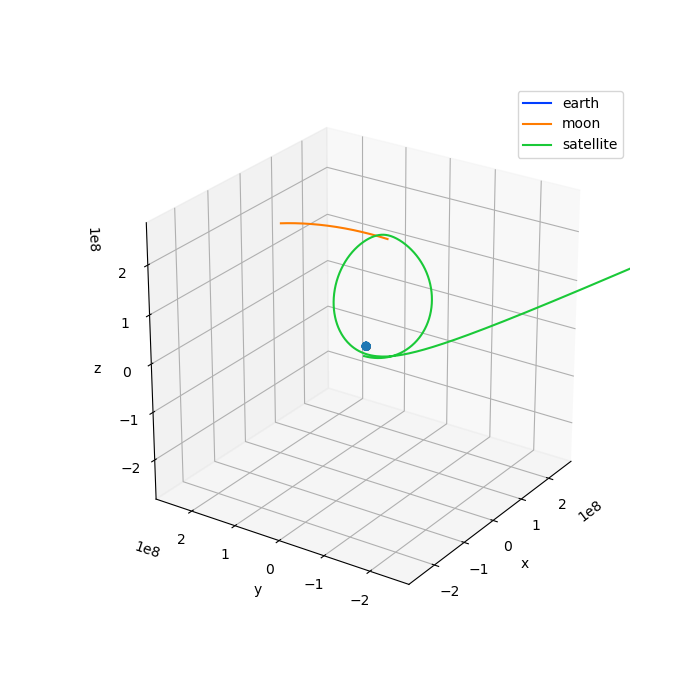

In [67]:
%matplotlib notebook

# The next step is to decellerate once in the Moons sphere of influence.
viz(integrated).plot_orbit(.001)